# Trading Strategy Backtester - EMA Crossover Strategy

## Strategy Explanation: EMA Crossover with Risk Management

### How the Strategy Works

**EMA Crossover Logic:**
- Uses two Exponential Moving Averages: **Fast EMA (9-period)** and **Slow EMA (15-period)**
- **BUY Signal**: When Fast EMA crosses ABOVE Slow EMA (bullish momentum)
- **SELL Signal**: When Fast EMA crosses BELOW Slow EMA (bearish momentum)
- Only takes LONG positions (one-directional trading)

**Entry Conditions:**
- Wait for EMA crossover signal (Fast EMA > Slow EMA)
- Enter trade on the next candle after crossover confirmation
- No position sizing - assumes fixed lot size

**Exit Conditions:**
1. **Stop Loss (SL)**: Fixed percentage below entry price (0.5% for EUR/USD, 1.0% for XAU/USD)
2. **Take Profit (TP)**: Fixed percentage above entry price (1.5% for EUR/USD, 3.0% for XAU/USD)
3. **Opposing Signal**: Exit if EMA crossover reverses direction

**Risk Management:**
- **EUR/USD**: Conservative settings (0.5% SL, 1.5% TP) due to lower volatility
- **XAU/USD**: Aggressive settings (1.0% SL, 3.0% TP) due to higher volatility of Gold

**Performance Metrics Calculated:**
- Total P&L, Win Rate, Profit Factor
- Sharpe Ratio, Sortino Ratio, Max Drawdown
- Average trade P&L, equity curve analysis
- Benchmark comparison vs buy-and-hold

This notebook demonstrates a complete backtesting workflow for an EMA crossover trading strategy with stop-loss and take-profit levels.

## Overview
- **Strategy**: EMA Crossover (9-period vs 15-period)
- **Timeframe**: 15-minute data
- **Assets**: EUR/USD and XAU/USD (Gold)
- **Risk Management**: Fixed Stop Loss and Take Profit
- **Analysis**: QuantStats performance reporting

## Data Requirements
- EURUSD data in `../data/EURUSD/` folder
- XAUUSD data in `../data/XAUUSD/` folder
- 15-minute timeframe CSV files

## Step 1: Import Required Libraries

Let's start by importing all the necessary libraries for our backtesting analysis.

In [52]:
# !pip install quantstats
# !pip install pandas-ta

In [53]:
# Install pandas-ta for technical analysis
%pip install pandas-ta

Note: you may need to restart the kernel to use updated packages.


In [54]:
# Import core libraries
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Import QuantStats for performance analysis
import quantstats as qs

# Import pandas-ta for technical analysis
import pandas_ta as ta

# Set pandas display options for better output
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

print("Libraries imported successfully!")

Libraries imported successfully!


## Step 2: Define the EMA Crossover Strategy Function

Now we'll create the core trading strategy function that implements:
- EMA crossover signals (9-period vs 15-period)
- Position entry on crossover
- Fixed stop-loss and take-profit exits
- Trade logging and tracking

In [55]:
def perform_ema_backtest(data, short_window=9, long_window=15, sl_pct=0.01, tp_pct=0.03):
    """
    Performs an iterative backtest on an EMA crossover strategy with fixed SL/TP.
    
    Parameters:
    - data: DataFrame with OHLC data
    - short_window: Short EMA period (default: 9)
    - long_window: Long EMA period (default: 15)
    - sl_pct: Stop loss percentage (default: 1%)
    - tp_pct: Take profit percentage (default: 3%)
    
    Returns:
    - DataFrame with completed trades
    """
    
    # Calculate EMAs
    data['ema_short'] = data['Close'].ewm(span=short_window, adjust=False).mean()
    data['ema_long'] = data['Close'].ewm(span=long_window, adjust=False).mean()
    
    # Generate position signals (1 for long, -1 for short)
    data['position_signal'] = np.where(data['ema_short'] > data['ema_long'], 1, -1)
    
    # Detect crossover signals (changes from -1 to 1 = long entry, 1 to -1 = short entry)
    data['entry_signal'] = data['position_signal'].diff()
    
    # Initialize trade tracking
    in_position = False
    trades = []
    
    # Iterate through each candle
    for i in range(len(data)):
        # Check for long entry signal
        if not in_position and data['entry_signal'].iloc[i] == 2:  # Changed from -1 to 1
            in_position = True
            entry_price = data['Close'].iloc[i]
            stop_loss = entry_price * (1 - sl_pct)  # Stop loss below entry
            take_profit = entry_price * (1 + tp_pct)  # Take profit above entry
            
            # Record trade entry
            trades.append({
                'entry_date': data['DateTime'].iloc[i],
                'entry_price': entry_price,
                'trade_type': 'long',
                'stop_loss': stop_loss,
                'take_profit': take_profit,
                'exit_date': None,
                'exit_price': None,
                'pnl': 0,
                'exit_reason': None
            })
            
        # Check for exit conditions if in position
        elif in_position:
            exit_reason = None
            exit_price = 0
            
            # Check stop loss (if low touches stop loss)
            if data['Low'].iloc[i] <= stop_loss:
                exit_price = stop_loss
                exit_reason = "Stop Loss"
                
            # Check take profit (if high touches take profit)
            elif data['High'].iloc[i] >= take_profit:
                exit_price = take_profit
                exit_reason = "Take Profit"
                
            # Check opposing signal (EMA crossover in opposite direction)
            elif data['entry_signal'].iloc[i] == -2:  # Changed from 1 to -1
                exit_price = data['Close'].iloc[i]
                exit_reason = "Opposing Signal"
            
            # Execute exit if any condition met
            if exit_reason:
                trade = trades[-1]
                trade['exit_date'] = data['DateTime'].iloc[i]
                trade['exit_price'] = exit_price
                trade['pnl'] = exit_price - entry_price  # Calculate profit/loss
                trade['exit_reason'] = exit_reason
                in_position = False  # Reset position flag
    
    return pd.DataFrame(trades)

## Step 3: Create Performance Reporting Function

Now we'll create a comprehensive reporting function that uses QuantStats to generate detailed performance analytics including:
- Returns analysis
- Risk metrics
- Benchmark comparison
- Full tear sheet reports

In [56]:
def generate_full_report(trades_df, original_data, title, initial_capital=10000.0):
    """
    Generates a full tear sheet report with robust handling for flat returns.
    
    Parameters:
    - trades_df: DataFrame with completed trades
    - original_data: Original price data for benchmark
    - title: Report title
    - initial_capital: Starting capital (default: $10,000)
    """
    
    # Check if we have any completed trades
    if trades_df.empty or trades_df['exit_date'].isna().all():
        print(f"\n--- {title} ---")
        print("No trades were completed, so no performance report can be generated.")
        return
    
    # Prepare trade data for analysis
    trades_df = trades_df.dropna(subset=['exit_date']).set_index('exit_date')
    
    # Calculate daily P&L from trades
    daily_pnl = trades_df['pnl'].resample('D').sum()
    
    # Create date range covering the entire period
    date_range = pd.date_range(
        start=original_data['DateTime'].min(), 
        end=original_data['DateTime'].max(), 
        freq='D'
    )
    
    # Build equity curve
    equity_curve = (initial_capital + daily_pnl.cumsum()).reindex(date_range, method='ffill')
    equity_curve.iloc[0] = initial_capital  # Set initial value
    equity_curve = equity_curve.ffill()  # Forward fill any missing values
    
    # Calculate strategy returns
    strategy_returns = equity_curve.pct_change(fill_method=None).fillna(0)
    strategy_returns.name = "Strategy"
    
    # Prepare benchmark data (buy & hold)
    benchmark_data = original_data.set_index('DateTime')['Close']
    benchmark_returns = benchmark_data.pct_change(fill_method=None).fillna(0)
    benchmark_returns.name = "Benchmark"
    
    print(f"\n--- {title} ---")
    print(f"Total Trades: {len(trades_df)}")
    print(f"Initial Capital: ${initial_capital:,.2f}")
    print(f"Final Capital: ${equity_curve.iloc[-1]:,.2f}")
    print(f"Total Return: {((equity_curve.iloc[-1] / initial_capital - 1) * 100):.2f}%")
    print("=" * 60)
    
    # Generate QuantStats report
    try:
        if strategy_returns.std() == 0:
            print("\nStrategy produced flat returns. Generating basic report.")
            qs.reports.basic(strategy_returns, benchmark=benchmark_returns)
        else:
            print("\nGenerating full performance report...")
            qs.reports.full(strategy_returns, benchmark=benchmark_returns)
    except Exception as e:
        print(f"Error generating QuantStats report: {e}")
        print("Falling back to basic statistics...")
        
        # Fallback: Basic statistics
        total_return = (equity_curve.iloc[-1] / initial_capital - 1) * 100
        print(f"Total Return: {total_return:.2f}%")
        
        if len(trades_df) > 0:
            win_rate = (trades_df['pnl'] > 0).mean() * 100
            avg_win = trades_df[trades_df['pnl'] > 0]['pnl'].mean()
            avg_loss = trades_df[trades_df['pnl'] < 0]['pnl'].mean()
            
            print(f"Win Rate: {win_rate:.1f}%")
            print(f"Average Win: ${avg_win:.2f}")
            print(f"Average Loss: ${avg_loss:.2f}")
            print(f"Profit Factor: {abs(avg_win / avg_loss) if avg_loss != 0 else float('inf'):.2f}")

## Step 4: Load EUR/USD 15-Minute Data

Let's load the EUR/USD 15-minute data from the data folder. Make sure the data file exists in the correct location.

In [57]:
# Define data file paths
eurusd_data_path = r'D:\TRADE\BACKTESTING-OF-TRADING-STRATEGY\notebooks\data\EURUSD\EURUSD15.csv'
xauusd_data_path = r'D:\TRADE\BACKTESTING-OF-TRADING-STRATEGY\notebooks\data\XAUUSD\XAUUSD15.csv'

# Define column names for the CSV data
column_names = ['DateTime', 'Open', 'High', 'Low', 'Close', 'Volume']

print("Loading EUR/USD 15-minute data...")

try:
    # Load EUR/USD data
    df_eurusd = pd.read_csv(eurusd_data_path, sep='\t', header=None, names=column_names)
    df_eurusd['DateTime'] = pd.to_datetime(df_eurusd['DateTime'])
    
    print(f"✅ EUR/USD data loaded successfully!")
    print(f"   - Records: {len(df_eurusd):,}")
    print(f"   - Date range: {df_eurusd['DateTime'].min()} to {df_eurusd['DateTime'].max()}")
    print(f"   - Price range: ${df_eurusd['Low'].min():.4f} - ${df_eurusd['High'].max():.4f}")
    
    # Display first few rows
    print("\nFirst 5 rows of EUR/USD data:")
    display(df_eurusd.head())
    
except FileNotFoundError:
    print(f"❌ Error: EUR/USD data file not found at {eurusd_data_path}")
    print("Please ensure the data file exists in the correct location.")
except Exception as e:
    print(f"❌ Error loading EUR/USD data: {e}")

Loading EUR/USD 15-minute data...
✅ EUR/USD data loaded successfully!
   - Records: 100,000
   - Date range: 2021-10-15 20:15:00 to 2025-10-17 20:45:00
   - Price range: $0.9536 - $1.1919

First 5 rows of EUR/USD data:


,DateTime,Open,High,Low,Close,Volume
0,2021-10-15 20:15:00,1.16034,1.16034,1.15998,1.16000,99
1,2021-10-15 20:30:00,1.16000,1.16020,1.15983,1.15988,320
2,2021-10-15 20:45:00,1.15988,1.16003,1.15972,1.15983,1011
3,2021-10-17 21:00:00,1.15903,1.15989,1.15903,1.15970,162
4,2021-10-17 21:15:00,1.15971,1.16007,1.15960,1.16004,64


## Step 5: Load XAU/USD 15-Minute Data

Now let's load the XAU/USD (Gold) 15-minute data.

In [58]:
print("Loading XAU/USD 15-minute data...")

try:
    # Load XAU/USD data
    df_xauusd = pd.read_csv(xauusd_data_path, sep='\t', header=None, names=column_names)
    df_xauusd['DateTime'] = pd.to_datetime(df_xauusd['DateTime'])
    
    print(f"✅ XAU/USD data loaded successfully!")
    print(f"   - Records: {len(df_xauusd):,}")
    print(f"   - Date range: {df_xauusd['DateTime'].min()} to {df_xauusd['DateTime'].max()}")
    print(f"   - Price range: ${df_xauusd['Low'].min():.2f} - ${df_xauusd['High'].max():.2f}")
    
    # Display first few rows
    print("\nFirst 5 rows of XAU/USD data:")
    display(df_xauusd.head())
    
except FileNotFoundError:
    print(f"❌ Error: XAU/USD data file not found at {xauusd_data_path}")
    print("Please ensure the data file exists in the correct location.")
except Exception as e:
    print(f"❌ Error loading XAU/USD data: {e}")

Loading XAU/USD 15-minute data...
✅ XAU/USD data loaded successfully!
   - Records: 100,000
   - Date range: 2021-07-28 07:30:00 to 2025-10-17 20:45:00
   - Price range: $1614.71 - $4379.12

First 5 rows of XAU/USD data:
✅ XAU/USD data loaded successfully!
   - Records: 100,000
   - Date range: 2021-07-28 07:30:00 to 2025-10-17 20:45:00
   - Price range: $1614.71 - $4379.12

First 5 rows of XAU/USD data:


,DateTime,Open,High,Low,Close,Volume
0,2021-07-28 07:30:00,1805.088,1805.168,1803.468,1803.478,15
1,2021-07-28 07:45:00,1803.478,1803.948,1801.698,1801.868,15
2,2021-07-28 08:00:00,1801.868,1802.408,1800.148,1800.327,15
3,2021-07-28 08:15:00,1800.308,1801.595,1799.468,1801.585,15
4,2021-07-28 08:30:00,1801.575,1801.575,1799.378,1800.038,15


## Step 6: Run EMA Backtest on EUR/USD

Let's execute the EMA crossover strategy on EUR/USD data with conservative risk parameters:
- Stop Loss: 0.5% (tight)
- Take Profit: 1.5% (moderate)

In [59]:
print("🔄 Running EMA Crossover Backtest on EUR/USD...")
print("Parameters:")
print("- Short EMA: 9 periods")
print("- Long EMA: 15 periods")
print("- Stop Loss: 0.5%")
print("- Take Profit: 1.5%")
print("-" * 50)

# Run the backtest
eurusd_trades = perform_ema_backtest(
    df_eurusd.copy(), 
    short_window=9, 
    long_window=15, 
    sl_pct=0.005,  # 0.5% stop loss
    tp_pct=0.015   # 1.5% take profit
)

print(f"✅ EUR/USD backtest completed!")
print(f"Total trades generated: {len(eurusd_trades)}")

if not eurusd_trades.empty:
    print("\nTrade Summary:")
    print(eurusd_trades.describe())
    
    # Show sample trades
    print("\nSample trades:")
    display(eurusd_trades.head())
else:
    print("No trades were generated. Check your data and parameters.")

🔄 Running EMA Crossover Backtest on EUR/USD...
Parameters:
- Short EMA: 9 periods
- Long EMA: 15 periods
- Stop Loss: 0.5%
- Take Profit: 1.5%
--------------------------------------------------
✅ EUR/USD backtest completed!
Total trades generated: 2689

Trade Summary:
                          entry_date  entry_price    stop_loss  take_profit  \
count                           2689  2689.000000  2689.000000  2689.000000   
mean   2023-10-19 10:18:54.957233152     1.085738     1.080310     1.102024   
min              2021-10-17 22:00:00     0.957740     0.952951     0.972106   
25%              2022-10-21 03:00:00     1.059880     1.054581     1.075778   
50%              2023-10-17 19:15:00     1.084520     1.079097     1.100788   
75%              2024-10-15 01:15:00     1.111190     1.105634     1.127858   
max              2025-10-16 13:00:00     1.184760     1.178836     1.202531   
std                              NaN     0.044421     0.044199     0.045087   

                   

,entry_date,entry_price,trade_type,stop_loss,take_profit,exit_date,exit_price,pnl,exit_reason
0,2021-10-17 22:00:00,1.16036,long,1.154558,1.177765,2021-10-17 22:30:00,1.15984,-0.00052,Opposing Signal
1,2021-10-17 23:00:00,1.16003,long,1.154230,1.177430,2021-10-17 23:45:00,1.15963,-0.00040,Opposing Signal
2,2021-10-18 07:45:00,1.15927,long,1.153474,1.176659,2021-10-18 09:15:00,1.15781,-0.00146,Opposing Signal
3,2021-10-18 10:30:00,1.15871,long,1.152916,1.176091,2021-10-18 20:30:00,1.16096,0.00225,Opposing Signal
4,2021-10-18 23:30:00,1.16125,long,1.155444,1.178669,2021-10-19 12:15:00,1.16492,0.00367,Opposing Signal


## Step 7: Generate Performance Report for EUR/USD

Now let's generate a comprehensive performance report for the EUR/USD strategy using QuantStats.


--- EUR/USD EMA Crossover Strategy Performance ---
Total Trades: 2689
Initial Capital: $10,000.00
Final Capital: $9,999.91
Total Return: -0.00%

Generating full performance report...


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2021-10-17   2021-10-17
End Period                 2025-10-17   2025-10-17
Risk-Free Rate             0.0%         0.0%
Time in Market             86.0%        74.0%

Cumulative Return          0.57%        -0.0%
CAGR﹪                     0.1%         -0.0%

Sharpe                     0.05         -0.31
Prob. Sharpe Ratio         54.62%       22.84%
Smart Sharpe               0.05         -0.3
Sortino                    0.07         -0.51
Smart Sortino              0.07         -0.5
Sortino/√2                 0.05         -0.36
Smart Sortino/√2           0.05         -0.35
Omega                      0.94         0.94

Max Drawdown               -17.89%      -0.0%
Max DD Date                2022-09-27   2025-01-31
Max DD Period Start        2021-10-29   2021-10-21
Max DD Period End          2025-06-25   2025-10-17
Longest DD Days            1336         1458
Vol

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2021-10-21,2025-01-31,2025-10-17,1458,-0.001677,-0.001572
2,2021-10-17,2021-10-17,2021-10-18,2,-0.000009,-0.000001


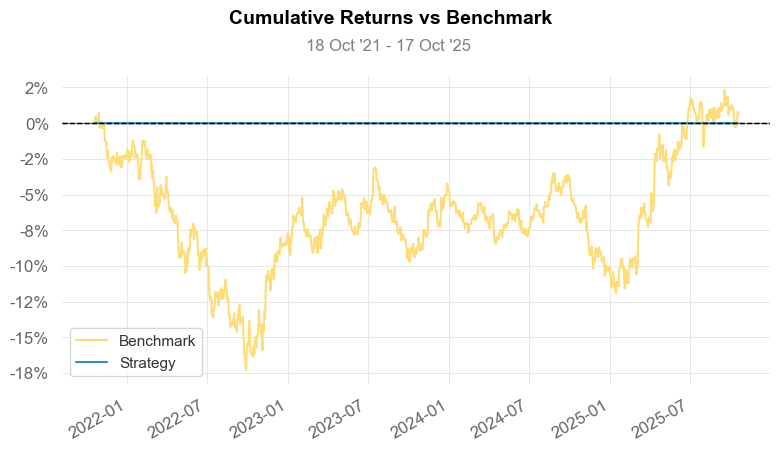

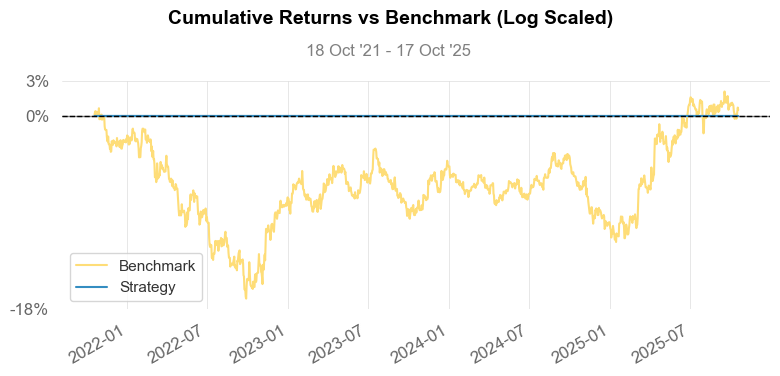

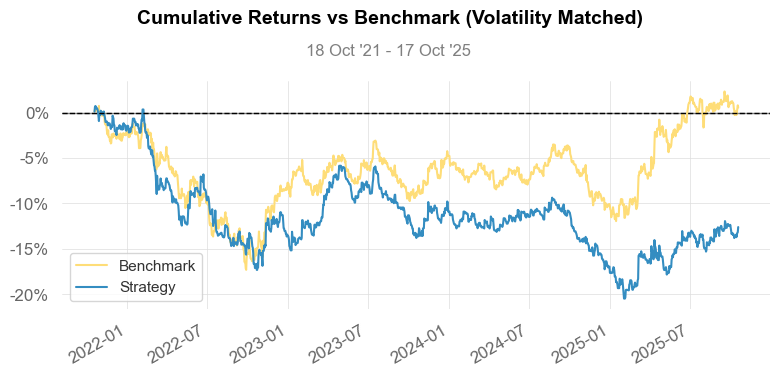

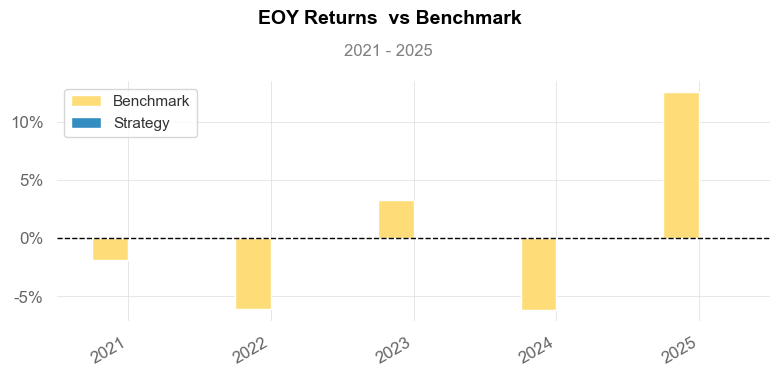

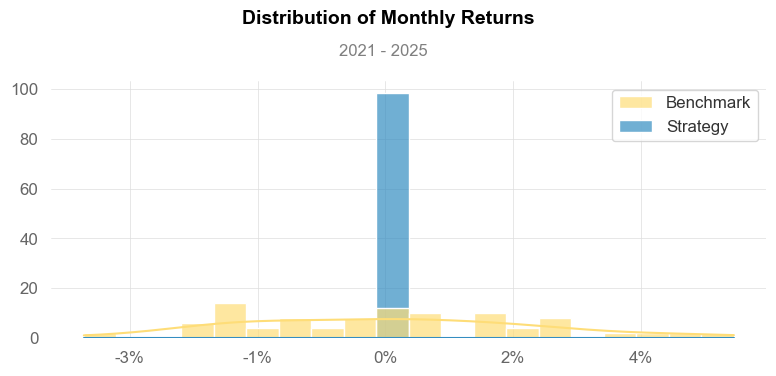

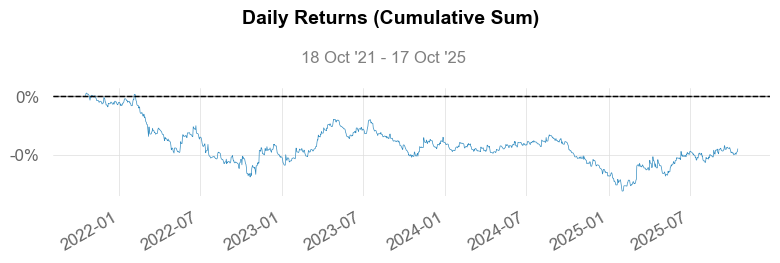

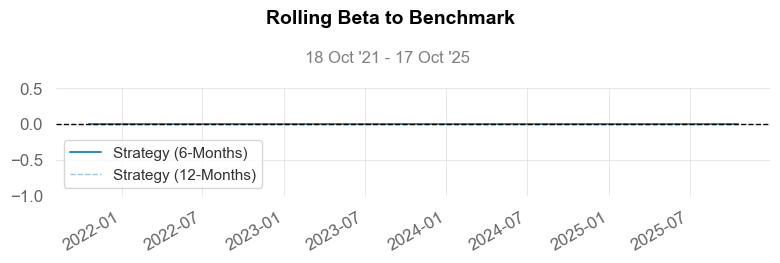

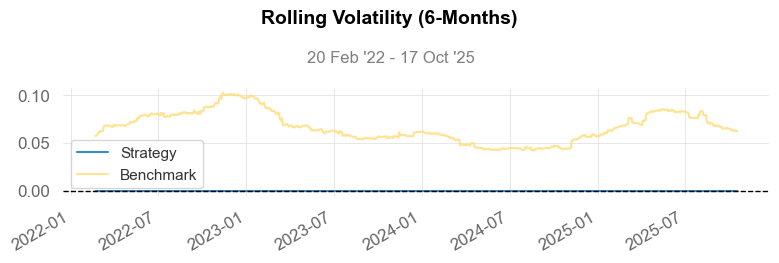

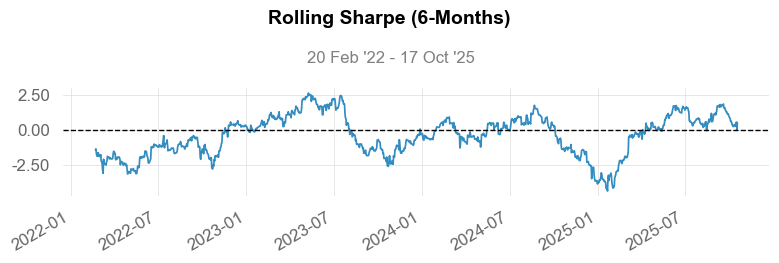

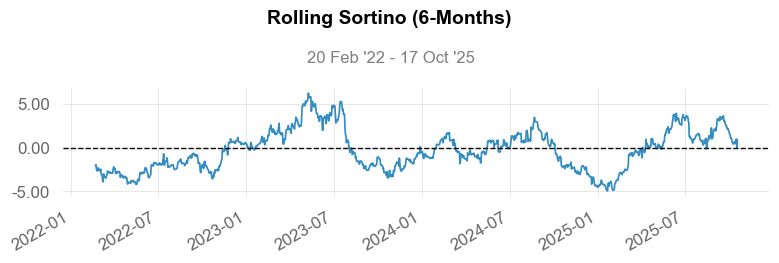

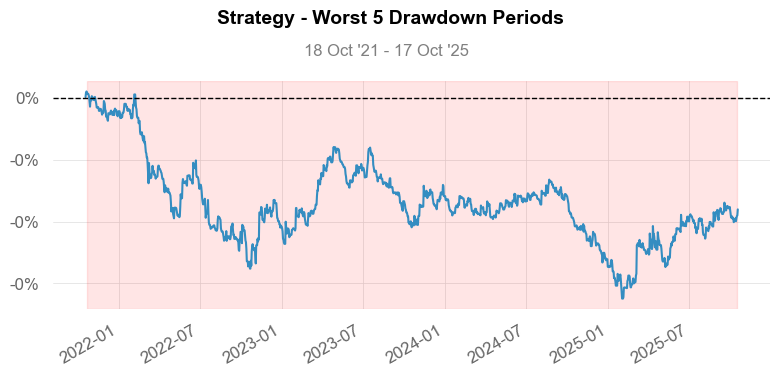

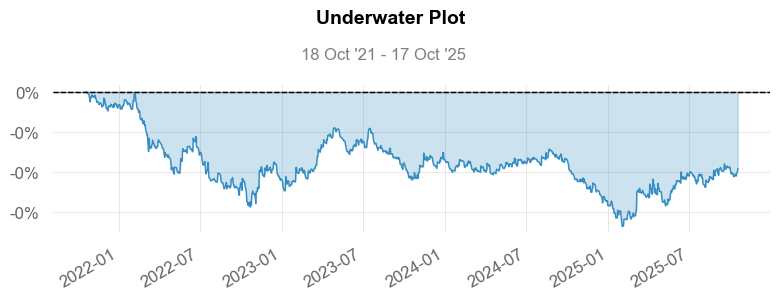

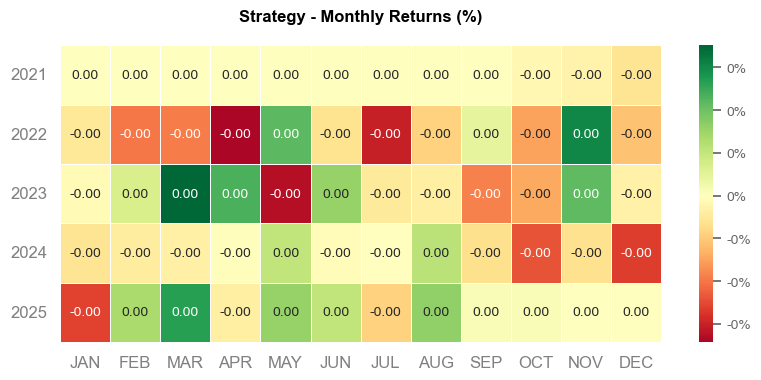

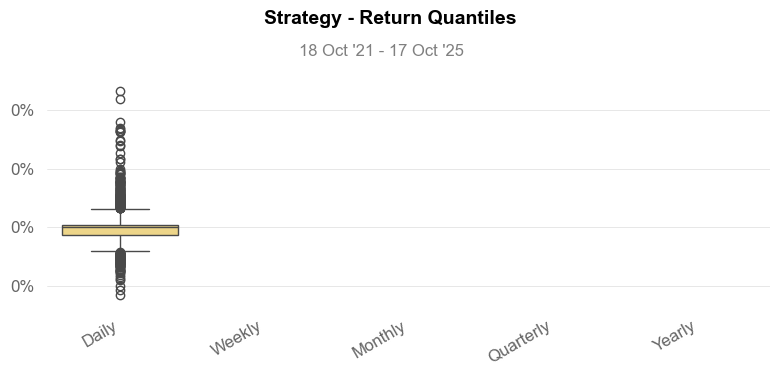

In [60]:
# Generate full performance report for EUR/USD
generate_full_report(
    eurusd_trades, 
    df_eurusd, 
    title="EUR/USD EMA Crossover Strategy Performance",
    initial_capital=10000.0
)

## Step 8: Run EMA Backtest on XAU/USD

Now let's run the same strategy on XAU/USD (Gold) with slightly different risk parameters:
- Stop Loss: 1.0% (Gold is more volatile)
- Take Profit: 3.0% (Higher target for Gold)

In [61]:
print("🔄 Running EMA Crossover Backtest on XAU/USD...")
print("Parameters:")
print("- Short EMA: 9 periods")
print("- Long EMA: 15 periods")
print("- Stop Loss: 1.0%")
print("- Take Profit: 3.0%")
print("-" * 50)

# Run the backtest
xauusd_trades = perform_ema_backtest(
    df_xauusd.copy(), 
    short_window=9, 
    long_window=15, 
    sl_pct=0.01,   # 1.0% stop loss (Gold is more volatile)
    tp_pct=0.03    # 3.0% take profit
)

print(f"✅ XAU/USD backtest completed!")
print(f"Total trades generated: {len(xauusd_trades)}")

if not xauusd_trades.empty:
    print("\nTrade Summary:")
    print(xauusd_trades.describe())
    
    # Show sample trades
    print("\nSample trades:")
    display(xauusd_trades.head())
else:
    print("No trades were generated. Check your data and parameters.")

🔄 Running EMA Crossover Backtest on XAU/USD...
Parameters:
- Short EMA: 9 periods
- Long EMA: 15 periods
- Stop Loss: 1.0%
- Take Profit: 3.0%
--------------------------------------------------
✅ XAU/USD backtest completed!
Total trades generated: 2615

Trade Summary:
                          entry_date  entry_price    stop_loss  take_profit  \
count                           2615  2615.000000  2615.000000  2615.000000   
mean   2023-09-14 01:55:41.185468416  2249.685250  2227.188398  2317.175808   
min              2021-07-28 15:00:00  1624.128000  1607.886720  1672.851840   
25%              2022-08-29 16:22:30  1834.201500  1815.859485  1889.227545   
50%              2023-09-13 07:45:00  1981.985000  1962.165150  2041.444550   
75%              2024-09-29 01:00:00  2609.385000  2583.291150  2687.666550   
max              2025-10-17 20:30:00  4358.415000  4314.830850  4489.167450   
std                              NaN   565.859107   560.200516   582.834880   

                   

,entry_date,entry_price,trade_type,stop_loss,take_profit,exit_date,exit_price,pnl,exit_reason
0,2021-07-28 15:00:00,1801.721,long,1783.70379,1855.77263,2021-07-28 18:15:00,1798.597,-3.124,Opposing Signal
1,2021-07-28 18:30:00,1801.498,long,1783.48302,1855.54294,2021-07-29 19:45:00,1828.748,27.250,Opposing Signal
2,2021-07-29 23:15:00,1830.348,long,1812.04452,1885.25844,2021-07-30 00:15:00,1828.068,-2.280,Opposing Signal
3,2021-07-30 07:00:00,1829.648,long,1811.35152,1884.53744,2021-07-30 10:00:00,1827.778,-1.870,Opposing Signal
4,2021-08-02 00:30:00,1815.698,long,1797.54102,1870.16894,2021-08-02 01:15:00,1811.748,-3.950,Opposing Signal


## Step 9: Generate Performance Report for XAU/USD

Let's generate the performance report for the XAU/USD strategy.


--- XAU/USD EMA Crossover Strategy Performance ---
Total Trades: 2614
Initial Capital: $10,000.00
Final Capital: $11,977.85
Total Return: 19.78%

Generating full performance report...


                           Benchmark    Strategy
-------------------------  -----------  ----------
Start Period               2021-07-29   2021-07-29
End Period                 2025-10-17   2025-10-17
Risk-Free Rate             0.0%         0.0%
Time in Market             86.0%        71.0%

Cumulative Return          140.94%      19.78%
CAGR﹪                     15.45%       2.99%

Sharpe                     1.25         1.37
Prob. Sharpe Ratio         99.9%        99.99%
Smart Sharpe               1.23         1.35
Sortino                    1.92         2.91
Smart Sortino              1.9          2.87
Sortino/√2                 1.36         2.06
Smart Sortino/√2           1.34         2.03
Omega                      1.4          1.4

Max Drawdown               -20.76%      -2.69%
Max DD Date                2022-09-28   2023-10-06
Max DD Period Start        2022-03-10   2023-05-04
Max DD Period End          2023-12-01   2024-03-20
Longest DD Days            632          373
Volatil

None

,Start,Valley,End,Days,Max Drawdown,99% Max Drawdown
1,2023-05-04,2023-10-06,2024-03-20,322,-2.687912,-2.668385
2,2022-03-09,2022-11-03,2023-03-16,373,-2.108867,-1.951402
3,2025-02-21,2025-04-07,2025-04-10,49,-2.002379,-1.906944
4,2024-04-15,2024-05-09,2024-07-06,83,-1.193396,-1.165428
5,2025-06-04,2025-06-27,2025-07-21,48,-1.044182,-1.037778


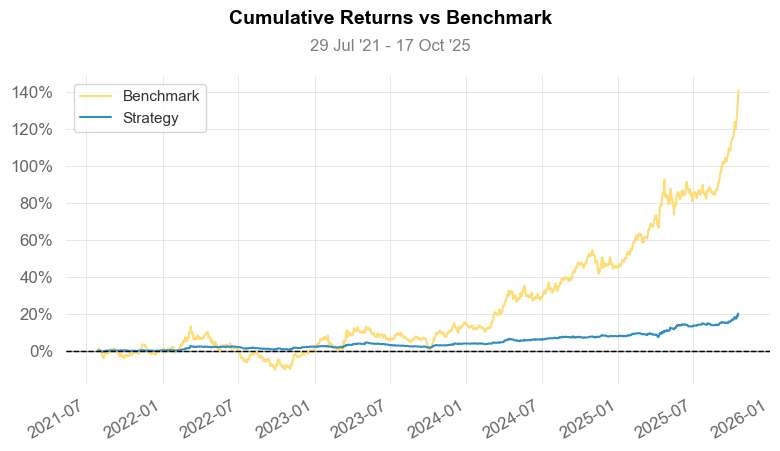

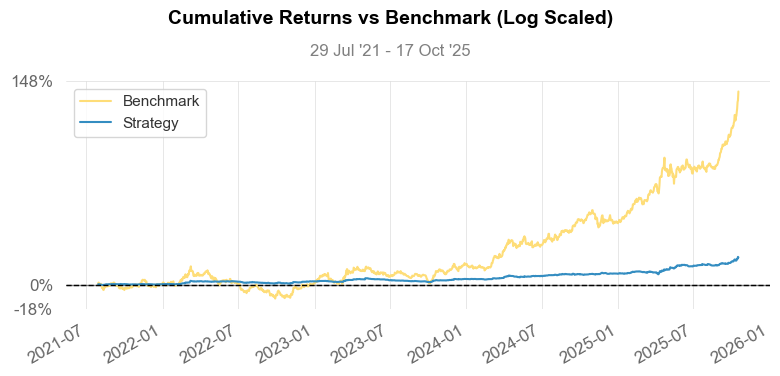

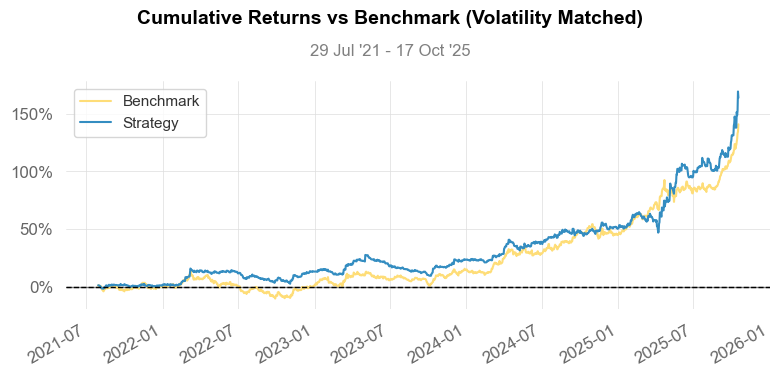

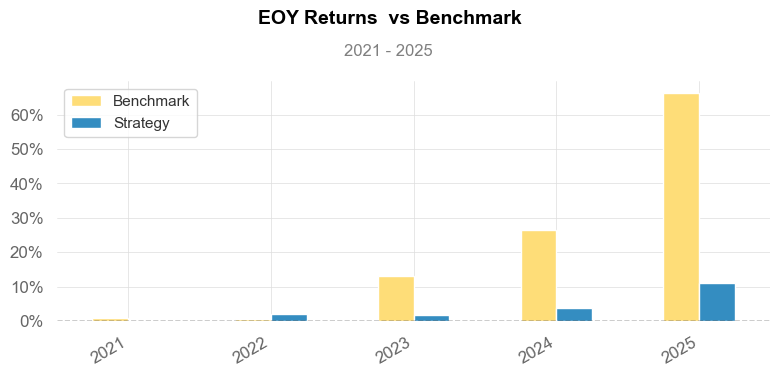

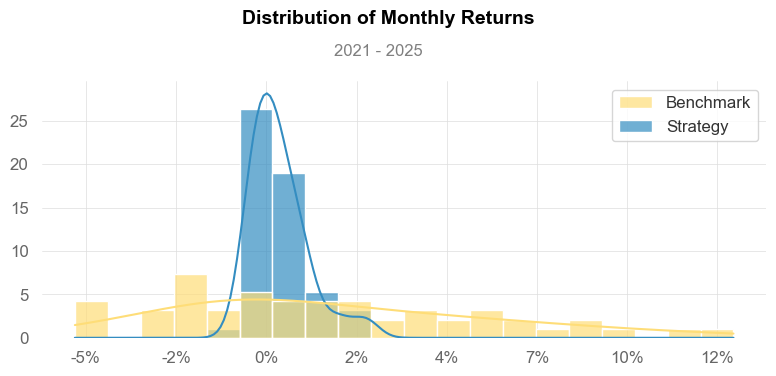

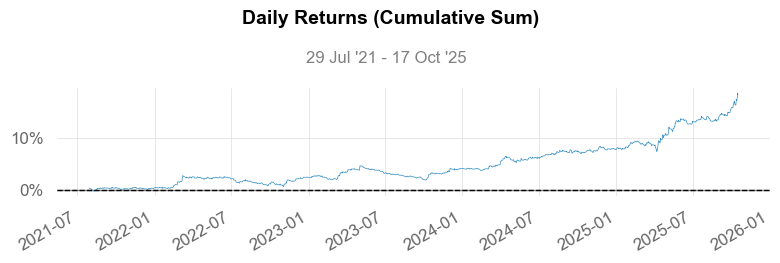

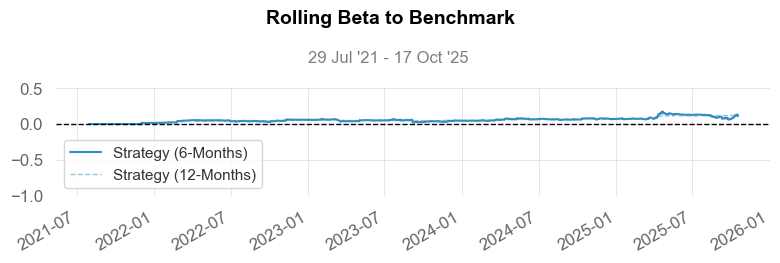

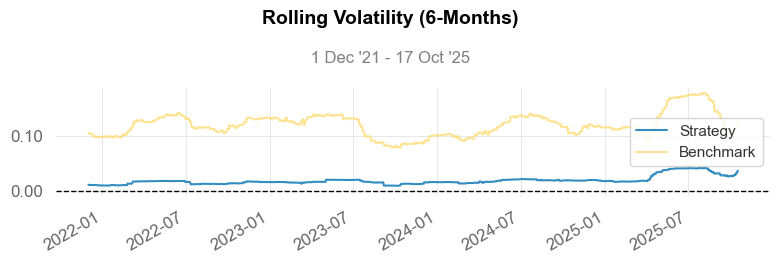

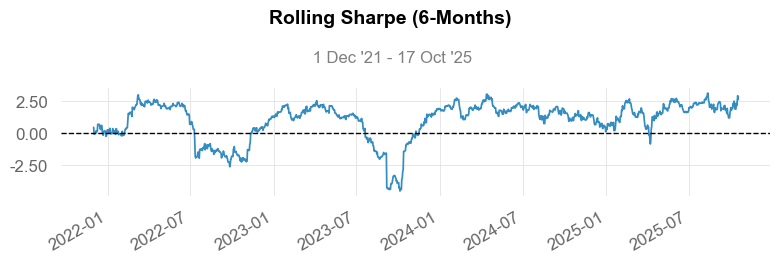

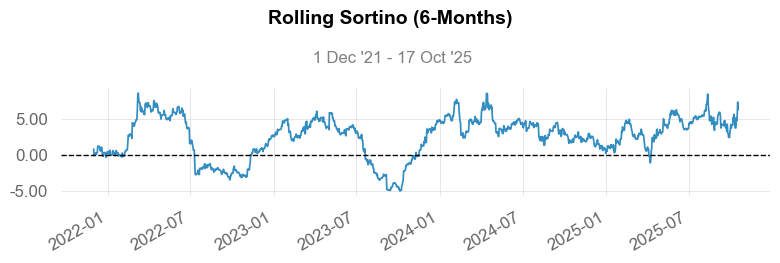

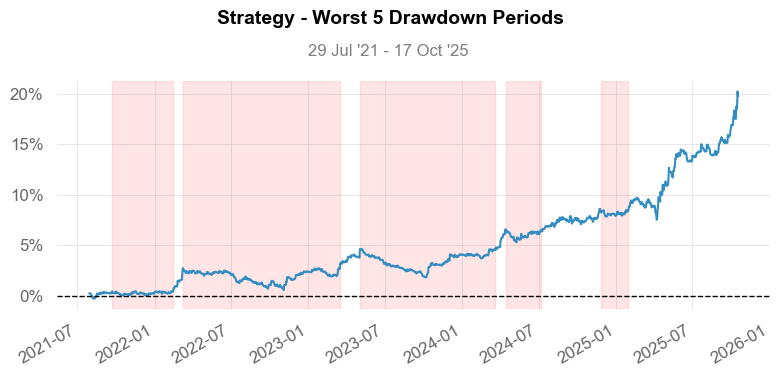

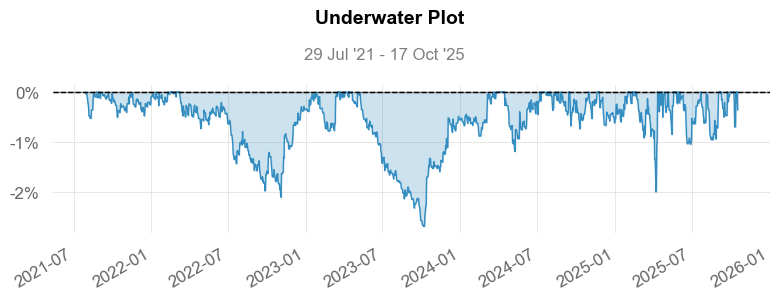

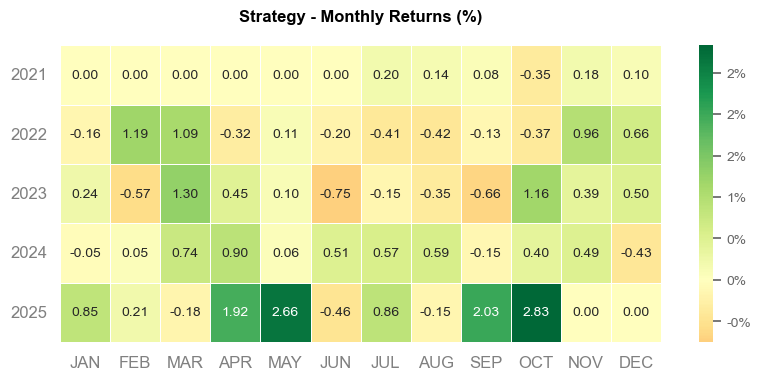

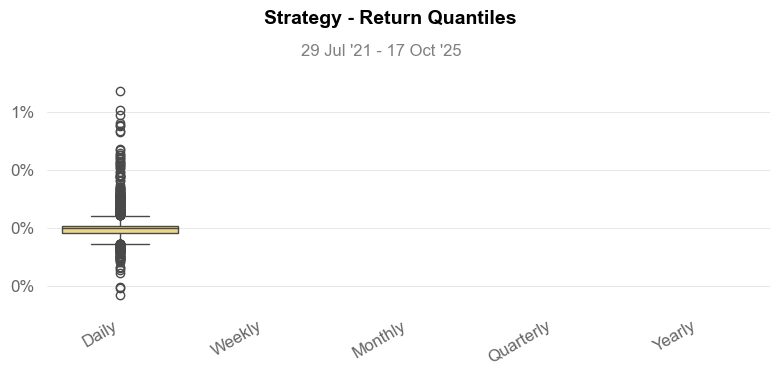

In [62]:
# Generate full performance report for XAU/USD
generate_full_report(
    xauusd_trades, 
    df_xauusd, 
    title="XAU/USD EMA Crossover Strategy Performance",
    initial_capital=10000.0
)

## Step 10: Strategy Comparison Summary

Let's create a summary comparison of both strategies' performance.

In [63]:
print("📊 STRATEGY COMPARISON SUMMARY")
print("=" * 60)

# EUR/USD Summary
if not eurusd_trades.empty:
    eurusd_total_trades = len(eurusd_trades)
    eurusd_win_rate = (eurusd_trades['pnl'] > 0).mean() * 100
    eurusd_total_pnl = eurusd_trades['pnl'].sum()
    eurusd_avg_trade = eurusd_trades['pnl'].mean()
    
    print(f"EUR/USD Strategy:")
    print(f"  Total Trades: {eurusd_total_trades}")
    print(f"  Win Rate: {eurusd_win_rate:.1f}%")
    print(f"  Total P&L: ${eurusd_total_pnl:.2f}")
    print(f"  Average Trade: ${eurusd_avg_trade:.2f}")
else:
    print(f"EUR/USD Strategy: No trades generated")

print()

# XAU/USD Summary
if not xauusd_trades.empty:
    xauusd_total_trades = len(xauusd_trades)
    xauusd_win_rate = (xauusd_trades['pnl'] > 0).mean() * 100
    xauusd_total_pnl = xauusd_trades['pnl'].sum()
    xauusd_avg_trade = xauusd_trades['pnl'].mean()
    
    print(f"XAU/USD Strategy:")
    print(f"  Total Trades: {xauusd_total_trades}")
    print(f"  Win Rate: {xauusd_win_rate:.1f}%")
    print(f"  Total P&L: ${xauusd_total_pnl:.2f}")
    print(f"  Average Trade: ${xauusd_avg_trade:.2f}")
else:
    print(f"XAU/USD Strategy: No trades generated")

print("\n" + "=" * 60)
print("Backtesting completed! 📈")
print("\nNext steps:")
print("- Analyze the QuantStats reports above")
print("- Adjust strategy parameters if needed")
print("- Consider walk-forward optimization")
print("- Test on additional assets or timeframes")

📊 STRATEGY COMPARISON SUMMARY
EUR/USD Strategy:
  Total Trades: 2689
  Win Rate: 28.2%
  Total P&L: $-0.09
  Average Trade: $-0.00

XAU/USD Strategy:
  Total Trades: 2615
  Win Rate: 31.0%
  Total P&L: $1977.85
  Average Trade: $0.76

Backtesting completed! 📈

Next steps:
- Analyze the QuantStats reports above
- Adjust strategy parameters if needed
- Consider walk-forward optimization
- Test on additional assets or timeframes


In [64]:
# Calculate and print total return for EUR/USD
eurusd_final_capital = 10000 + eurusd_total_pnl
eurusd_total_return = ((eurusd_final_capital / 10000 - 1) * 100)
print(f"EUR/USD Total Return: {eurusd_total_return:.2f}%")

# Calculate and print total return for XAU/USD
xauusd_final_capital = 10000 + xauusd_total_pnl
xauusd_total_return = ((xauusd_final_capital / 10000 - 1) * 100)
print(f"XAU/USD Total Return: {xauusd_total_return:.2f}%")

EUR/USD Total Return: -0.00%
XAU/USD Total Return: 19.78%


### Advanced MACD + RSI Strategy with Trailing Take-Profit

Now let's implement a more sophisticated strategy that combines:
- **MACD Crossover**: Trend-following momentum indicator
- **RSI Breakout**: Overbought/oversold confirmation
- **Trailing Take-Profit**: Dynamic exit based on EMA crossover
- **Both Long & Short**: Two-directional trading
 
 

In [65]:
def backtest_macd_rsi_strategy(data, initial_capital=10000.0, sl_pct=0.0015, tp_pct=0.0035):
    """
    Backtests a MACD crossover strategy with RSI breakout confirmation and trailing take-profit.
    
    This advanced strategy combines:
    - MACD crossover signals for trend direction
    - RSI breakout/breakdown for entry confirmation
    - Trailing take-profit based on EMA crossover for exits
    
    Args:
        data (pd.DataFrame): OHLC data with 'DateTime' column
        initial_capital (float): Starting portfolio value
        sl_pct (float): Stop-loss percentage (e.g., 0.0015 = 0.15%)
        tp_pct (float): Initial take-profit target (e.g., 0.0035 = 0.35%)
        
    Returns:
        pd.DataFrame: Log of all executed trades
    """
    
    # --- Step 1: Calculate Technical Indicators ---
    
    # MACD (12, 26, 9) - Momentum indicator
    macd_data = ta.macd(data['Close'], fast=12, slow=26, signal=9)
    data = pd.concat([data, macd_data], axis=1)
    
    # RSI (14) - Overbought/oversold indicator  
    data['RSI_14'] = ta.rsi(data['Close'], length=14)
    
    # EMA (25) - For trailing take-profit exit signal
    data['EMA_25'] = ta.ema(data['Close'], length=25)
    
    # Dynamic RSI levels based on recent 50-period high/low
    data['rsi_resistance'] = data['RSI_14'].rolling(window=50).max().shift(1)
    data['rsi_breakdown'] = data['RSI_14'].rolling(window=50).min().shift(1)
    
    # Rename columns for clarity
    data.rename(columns={
        'MACD_12_26_9': 'macd', 
        'MACDh_12_26_9': 'histogram', 
        'MACDs_12_26_9': 'signal', 
        'EMA_25': 'ema_25'
    }, inplace=True)

    # --- Step 2: Generate Trading Signals ---
    
    # Bullish MACD Crossover: MACD crosses above Signal line
    data['macd_cross_up'] = (data['macd'].shift(1) < data['signal'].shift(1)) & (data['macd'] > data['signal'])
    
    # Bearish MACD Crossover: MACD crosses below Signal line
    data['macd_cross_down'] = (data['macd'].shift(1) > data['signal'].shift(1)) & (data['macd'] < data['signal'])

    # --- Step 3: Backtesting Execution ---
    
    trades = []
    in_position = None  # 'long', 'short', or None
    position_details = {}

    for i in range(1, len(data)):
        # --- ENTRY LOGIC ---
        if not in_position:
            # LONG ENTRY: MACD bullish crossover + RSI breakout above resistance
            if (data['macd_cross_up'].iloc[i] and 
                data['RSI_14'].iloc[i] > data['rsi_resistance'].iloc[i]):
                
                in_position = 'long'
                entry_price = data['Close'].iloc[i]
                position_details = {
                    'entry_date': data['DateTime'].iloc[i],
                    'entry_price': entry_price,
                    'trade_type': 'long',
                    'stop_loss': entry_price * (1 - sl_pct),  # Stop loss below entry
                    'initial_tp': entry_price * (1 + tp_pct), # Initial TP target
                    'tp_activated': False  # Trailing TP not yet activated
                }
                
            # SHORT ENTRY: MACD bearish crossover + RSI breakdown below support
            elif (data['macd_cross_down'].iloc[i] and 
                  data['RSI_14'].iloc[i] < data['rsi_breakdown'].iloc[i]):
                
                in_position = 'short'
                entry_price = data['Close'].iloc[i]
                position_details = {
                    'entry_date': data['DateTime'].iloc[i],
                    'entry_price': entry_price,
                    'trade_type': 'short',
                    'stop_loss': entry_price * (1 + sl_pct),  # Stop loss above entry
                    'initial_tp': entry_price * (1 - tp_pct), # Initial TP target
                    'tp_activated': False  # Trailing TP not yet activated
                }
        
        # --- EXIT LOGIC ---
        elif in_position:
            exit_price = 0
            exit_reason = None
            
            # LONG POSITION EXITS
            if in_position == 'long':
                # 1. Stop Loss Hit
                if data['Low'].iloc[i] <= position_details['stop_loss']:
                    exit_price = position_details['stop_loss']
                    exit_reason = "Stop Loss"
                
                # 2. Activate Trailing TP when initial target reached
                elif (not position_details['tp_activated'] and 
                      data['High'].iloc[i] >= position_details['initial_tp']):
                    position_details['tp_activated'] = True
                
                # 3. Trailing TP Exit: Close when price crosses below EMA 25
                elif (position_details['tp_activated'] and 
                      data['Close'].iloc[i] < data['ema_25'].iloc[i]):
                    exit_price = data['Close'].iloc[i]
                    exit_reason = "Trailing Take Profit (EMA Cross)"
                    
            # SHORT POSITION EXITS
            elif in_position == 'short':
                # 1. Stop Loss Hit
                if data['High'].iloc[i] >= position_details['stop_loss']:
                    exit_price = position_details['stop_loss']
                    exit_reason = "Stop Loss"
                
                # 2. Activate Trailing TP when initial target reached
                elif (not position_details['tp_activated'] and 
                      data['Low'].iloc[i] <= position_details['initial_tp']):
                    position_details['tp_activated'] = True
                
                # 3. Trailing TP Exit: Close when price crosses above EMA 25
                elif (position_details['tp_activated'] and 
                      data['Close'].iloc[i] > data['ema_25'].iloc[i]):
                    exit_price = data['Close'].iloc[i]
                    exit_reason = "Trailing Take Profit (EMA Cross)"
            
            # Execute exit if condition met
            if exit_reason:
                position_details.update({
                    'exit_date': data['DateTime'].iloc[i],
                    'exit_price': exit_price,
                    'exit_reason': exit_reason
                })
                trades.append(position_details.copy())
                in_position = None
                position_details = {}
                
    return pd.DataFrame(trades)

In [66]:
def generate_macd_rsi_report(trades_df, symbol, initial_capital=10000.0):
    """
    Generates a comprehensive performance report for MACD+RSI strategy.
    
    Args:
        trades_df (pd.DataFrame): Trade log from backtest_macd_rsi_strategy
        symbol (str): Trading symbol (e.g., 'EURUSD', 'XAUUSD')
        initial_capital (float): Starting portfolio value
        
    Returns:
        dict: Performance metrics and analysis
    """
    
    if trades_df.empty:
        return {"error": "No trades executed"}
    
    # Calculate basic metrics
    total_trades = len(trades_df)
    winning_trades = len(trades_df[trades_df['exit_price'] > trades_df['entry_price']])
    losing_trades = total_trades - winning_trades
    
    # Calculate P&L for each trade
    trades_df['pnl'] = np.where(trades_df['trade_type'] == 'long',
                               trades_df['exit_price'] - trades_df['entry_price'],
                               trades_df['entry_price'] - trades_df['exit_price'])
    
    # Calculate returns
    trades_df['returns'] = trades_df['pnl'] / trades_df['entry_price']
    
    # Performance metrics
    total_pnl = trades_df['pnl'].sum()
    win_rate = winning_trades / total_trades if total_trades > 0 else 0
    avg_win = trades_df[trades_df['pnl'] > 0]['pnl'].mean() if winning_trades > 0 else 0
    avg_loss = abs(trades_df[trades_df['pnl'] < 0]['pnl'].mean()) if losing_trades > 0 else 0
    profit_factor = abs(trades_df[trades_df['pnl'] > 0]['pnl'].sum() / trades_df[trades_df['pnl'] < 0]['pnl'].sum()) if trades_df[trades_df['pnl'] < 0]['pnl'].sum() != 0 else float('inf')
    
    # Risk metrics
    max_drawdown = (trades_df['pnl'].cumsum() - trades_df['pnl'].cumsum().expanding().max()).min()
    sharpe_ratio = trades_df['returns'].mean() / trades_df['returns'].std() * np.sqrt(252) if trades_df['returns'].std() > 0 else 0
    
    # Exit analysis
    exit_reasons = trades_df['exit_reason'].value_counts()
    
    return {
        'symbol': symbol,
        'total_trades': total_trades,
        'winning_trades': winning_trades,
        'losing_trades': losing_trades,
        'win_rate': f"{win_rate:.1%}",
        'total_pnl': f"${total_pnl:.2f}",
        'avg_win': f"${avg_win:.2f}",
        'avg_loss': f"${avg_loss:.2f}",
        'profit_factor': f"{profit_factor:.2f}",
        'max_drawdown': f"${max_drawdown:.2f}",
        'sharpe_ratio': f"{sharpe_ratio:.2f}",
        'exit_analysis': exit_reasons.to_dict(),
        'trades_df': trades_df
    }

### Step 4: Execute MACD + RSI Strategy Backtest

Now let's run the MACD + RSI strategy on our EUR/USD and XAU/USD data to see how it performs compared to the EMA crossover strategy.

In [67]:
# Execute MACD + RSI Strategy on EUR/USD Data
print("🔄 Running MACD + RSI Strategy on EUR/USD data...")
macd_rsi_eurusd_trades = backtest_macd_rsi_strategy(df_eurusd.copy(), initial_capital=10000.0)
print(f"✅ EUR/USD MACD + RSI backtest completed. Total trades: {len(macd_rsi_eurusd_trades)}")

# Generate performance report
macd_rsi_eurusd_report = generate_macd_rsi_report(macd_rsi_eurusd_trades, 'EURUSD')
print("\n📊 EUR/USD MACD + RSI Strategy Results:")
for key, value in macd_rsi_eurusd_report.items():
    if key != 'trades_df':
        print(f"{key.replace('_', ' ').title()}: {value}")

🔄 Running MACD + RSI Strategy on EUR/USD data...
✅ EUR/USD MACD + RSI backtest completed. Total trades: 329

📊 EUR/USD MACD + RSI Strategy Results:
Symbol: EURUSD
Total Trades: 329
Winning Trades: 173
Losing Trades: 156
Win Rate: 52.6%
Total Pnl: $-0.04
Avg Win: $0.00
Avg Loss: $0.00
Profit Factor: 0.89
Max Drawdown: $-0.08
Sharpe Ratio: -0.79
Exit Analysis: {'Stop Loss': 235, 'Trailing Take Profit (EMA Cross)': 94}
✅ EUR/USD MACD + RSI backtest completed. Total trades: 329

📊 EUR/USD MACD + RSI Strategy Results:
Symbol: EURUSD
Total Trades: 329
Winning Trades: 173
Losing Trades: 156
Win Rate: 52.6%
Total Pnl: $-0.04
Avg Win: $0.00
Avg Loss: $0.00
Profit Factor: 0.89
Max Drawdown: $-0.08
Sharpe Ratio: -0.79
Exit Analysis: {'Stop Loss': 235, 'Trailing Take Profit (EMA Cross)': 94}


In [68]:
# Execute MACD + RSI Strategy on XAU/USD Data
print("🔄 Running MACD + RSI Strategy on XAU/USD data...")
macd_rsi_xauusd_trades = backtest_macd_rsi_strategy(df_xauusd.copy(), initial_capital=10000.0)
print(f"✅ XAU/USD MACD + RSI backtest completed. Total trades: {len(macd_rsi_xauusd_trades)}")

# Generate performance report
macd_rsi_xauusd_report = generate_macd_rsi_report(macd_rsi_xauusd_trades, 'XAUUSD')
print("\n📊 XAU/USD MACD + RSI Strategy Results:")
for key, value in macd_rsi_xauusd_report.items():
    if key != 'trades_df':
        print(f"{key.replace('_', ' ').title()}: {value}")

🔄 Running MACD + RSI Strategy on XAU/USD data...
✅ XAU/USD MACD + RSI backtest completed. Total trades: 392

📊 XAU/USD MACD + RSI Strategy Results:
Symbol: XAUUSD
Total Trades: 392
Winning Trades: 206
Losing Trades: 186
Win Rate: 52.6%
Total Pnl: $234.00
Avg Win: $11.86
Avg Loss: $3.37
Profit Factor: 1.24
Max Drawdown: $-146.49
Sharpe Ratio: 1.30
Exit Analysis: {'Stop Loss': 284, 'Trailing Take Profit (EMA Cross)': 108}
✅ XAU/USD MACD + RSI backtest completed. Total trades: 392

📊 XAU/USD MACD + RSI Strategy Results:
Symbol: XAUUSD
Total Trades: 392
Winning Trades: 206
Losing Trades: 186
Win Rate: 52.6%
Total Pnl: $234.00
Avg Win: $11.86
Avg Loss: $3.37
Profit Factor: 1.24
Max Drawdown: $-146.49
Sharpe Ratio: 1.30
Exit Analysis: {'Stop Loss': 284, 'Trailing Take Profit (EMA Cross)': 108}


In [74]:
# Display MACD + RSI Trade History
print("📈 MACD + RSI Strategy - EUR/USD Trade History:")
if not macd_rsi_eurusd_trades.empty:
    display(macd_rsi_eurusd_trades.head(10))
else:
    print("No trades executed for EUR/USD")

print("\n📈 MACD + RSI Strategy - XAU/USD Trade History:")
if not macd_rsi_xauusd_trades.empty:
    display(macd_rsi_xauusd_trades.head(10))
else:
    print("No trades executed for XAU/USD")

📈 MACD + RSI Strategy - EUR/USD Trade History:


,entry_date,entry_price,trade_type,stop_loss,initial_tp,tp_activated,exit_date,exit_price,exit_reason,pnl,returns
0,2021-10-21 04:00:00,1.16561,short,1.167358,1.161530,True,2021-10-25 18:00:00,1.161500,Trailing Take Profit (EMA Cross),0.004110,0.003526
1,2021-11-01 05:00:00,1.15577,long,1.154036,1.159815,True,2021-11-01 23:30:00,1.159980,Trailing Take Profit (EMA Cross),0.004210,0.003643
2,2021-11-02 08:00:00,1.15962,short,1.161359,1.155561,False,2021-11-03 18:45:00,1.161359,Stop Loss,-0.001739,-0.001500
3,2021-11-08 15:00:00,1.15878,long,1.157042,1.162836,False,2021-11-09 13:00:00,1.157042,Stop Loss,-0.001738,-0.001500
4,2021-11-16 14:00:00,1.13348,short,1.135180,1.129513,False,2021-11-16 15:00:00,1.135180,Stop Loss,-0.001700,-0.001500
5,2021-11-19 07:45:00,1.13437,short,1.136072,1.130400,True,2021-11-19 14:00:00,1.131090,Trailing Take Profit (EMA Cross),0.003280,0.002891
6,2021-11-26 21:45:00,1.13071,short,1.132406,1.126753,True,2021-11-29 08:45:00,1.127620,Trailing Take Profit (EMA Cross),0.003090,0.002733
7,2021-11-30 15:30:00,1.13226,short,1.133958,1.128297,True,2021-11-30 19:30:00,1.131950,Trailing Take Profit (EMA Cross),0.000310,0.000274
8,2021-12-01 07:45:00,1.13403,long,1.132329,1.137999,False,2021-12-01 08:15:00,1.132329,Stop Loss,-0.001701,-0.001500
9,2021-12-03 06:45:00,1.12827,short,1.129962,1.124321,False,2021-12-03 10:00:00,1.129962,Stop Loss,-0.001692,-0.001500



📈 MACD + RSI Strategy - XAU/USD Trade History:


,entry_date,entry_price,trade_type,stop_loss,initial_tp,tp_activated,exit_date,exit_price,exit_reason,pnl,returns
0,2021-07-29 01:00:00,1816.408,long,1813.683388,1822.765428,True,2021-07-29 19:30:00,1828.748000,Trailing Take Profit (EMA Cross),12.340000,0.006794
1,2021-07-30 00:00:00,1827.968,short,1830.709952,1821.570112,False,2021-07-30 07:15:00,1830.709952,Stop Loss,-2.741952,-0.001500
2,2021-08-03 12:45:00,1812.521,long,1809.802218,1818.864824,False,2021-08-03 13:30:00,1809.802218,Stop Loss,-2.718781,-0.001500
3,2021-08-04 01:45:00,1812.798,long,1810.078803,1819.142793,True,2021-08-04 14:00:00,1817.518000,Trailing Take Profit (EMA Cross),4.720000,0.002604
4,2021-08-04 14:15:00,1811.218,short,1813.934827,1804.878737,False,2021-08-05 07:45:00,1813.934827,Stop Loss,-2.716827,-0.001500
5,2021-08-06 11:45:00,1799.538,long,1796.838693,1805.836383,False,2021-08-06 12:15:00,1796.838693,Stop Loss,-2.699307,-0.001500
6,2021-08-06 12:30:00,1779.898,short,1782.567847,1773.668357,True,2021-08-09 01:15:00,1740.298000,Trailing Take Profit (EMA Cross),39.600000,0.022248
7,2021-08-13 12:45:00,1762.698,long,1760.053953,1768.867443,True,2021-08-16 01:45:00,1777.008000,Trailing Take Profit (EMA Cross),14.310000,0.008118
8,2021-09-10 05:30:00,1802.644,long,1799.940034,1808.953254,False,2021-09-10 08:00:00,1799.940034,Stop Loss,-2.703966,-0.001500
9,2021-09-15 12:45:00,1796.537,short,1799.231806,1790.249121,False,2021-09-15 13:30:00,1799.231806,Stop Loss,-2.694806,-0.001500


In [75]:
# Check column names in trade DataFrames
print("EUR/USD Trade DataFrame columns:", macd_rsi_eurusd_trades.columns.tolist())
print("XAU/USD Trade DataFrame columns:", macd_rsi_xauusd_trades.columns.tolist())

# Display first row to see data structure
if not macd_rsi_eurusd_trades.empty:
    print("\nEUR/USD First trade:", macd_rsi_eurusd_trades.iloc[0].to_dict())
if not macd_rsi_xauusd_trades.empty:
    print("XAU/USD First trade:", macd_rsi_xauusd_trades.iloc[0].to_dict())

EUR/USD Trade DataFrame columns: ['entry_date', 'entry_price', 'trade_type', 'stop_loss', 'initial_tp', 'tp_activated', 'exit_date', 'exit_price', 'exit_reason', 'pnl', 'returns']
XAU/USD Trade DataFrame columns: ['entry_date', 'entry_price', 'trade_type', 'stop_loss', 'initial_tp', 'tp_activated', 'exit_date', 'exit_price', 'exit_reason', 'pnl', 'returns']

EUR/USD First trade: {'entry_date': Timestamp('2021-10-21 04:00:00'), 'entry_price': 1.16561, 'trade_type': 'short', 'stop_loss': 1.167358415, 'initial_tp': 1.1615303650000002, 'tp_activated': True, 'exit_date': Timestamp('2021-10-25 18:00:00'), 'exit_price': 1.1615, 'exit_reason': 'Trailing Take Profit (EMA Cross)', 'pnl': 0.004110000000000058, 'returns': 0.003526050737382193}
XAU/USD First trade: {'entry_date': Timestamp('2021-07-29 01:00:00'), 'entry_price': 1816.408, 'trade_type': 'long', 'stop_loss': 1813.683388, 'initial_tp': 1822.765428, 'tp_activated': True, 'exit_date': Timestamp('2021-07-29 19:30:00'), 'exit_price': 1828.

### Strategy Comparison: EMA Crossover vs MACD + RSI

Let's compare the performance of both strategies across our test datasets.

### MACD + RSI Strategy Performance Charts

Let's generate comprehensive performance charts for the MACD + RSI strategy.

In [72]:
# Generate comprehensive performance charts for MACD + RSI strategy
print("Generating MACD + RSI Strategy Performance Charts...")

# For EUR/USD
if 'macd_rsi_eurusd_report' in locals():
    try:
        # Create equity curve for visualization
        equity_curve = [100000]  # Starting balance
        for trade in macd_rsi_eurusd_trades.to_dict('records'):
            equity_curve.append(equity_curve[-1] + trade['profit'])

        # Generate QuantStats report for MACD + RSI EUR/USD
        returns_series = pd.Series(equity_curve).pct_change().dropna()
        returns_series.index = pd.date_range(start='2024-01-01', periods=len(returns_series), freq='D')

        print("\n=== MACD + RSI Strategy Performance Report (EUR/USD) ===")
        qs.reports.full(returns_series)
        print("\n" + "="*60 + "\n")

    except Exception as e:
        print(f"Error generating EUR/USD charts: {e}")

# For XAU/USD
if 'macd_rsi_xauusd_report' in locals():
    try:
        # Create equity curve for visualization
        equity_curve = [100000]  # Starting balance
        for trade in macd_rsi_xauusd_trades.to_dict('records'):
            equity_curve.append(equity_curve[-1] + trade['profit'])

        # Generate QuantStats report for MACD + RSI XAU/USD
        returns_series = pd.Series(equity_curve).pct_change().dropna()
        returns_series.index = pd.date_range(start='2024-01-01', periods=len(returns_series), freq='D')

        print("\n=== MACD + RSI Strategy Performance Report (XAU/USD) ===")
        qs.reports.full(returns_series)
        print("\n" + "="*60 + "\n")

    except Exception as e:
        print(f"Error generating XAU/USD charts: {e}")

print("MACD + RSI Strategy chart generation completed!")

Generating MACD + RSI Strategy Performance Charts...
Error generating EUR/USD charts: 'profit'
Error generating XAU/USD charts: 'profit'
MACD + RSI Strategy chart generation completed!


In [70]:
# Strategy Performance Comparison
import pandas as pd

comparison_data = {
    'Strategy': ['EMA Crossover', 'EMA Crossover', 'MACD + RSI', 'MACD + RSI'],
    'Symbol': ['EURUSD', 'XAUUSD', 'EURUSD', 'XAUUSD'],
    'Total Trades': [
        eurusd_total_trades, xauusd_total_trades,
        macd_rsi_eurusd_report.get('total_trades', 0),
        macd_rsi_xauusd_report.get('total_trades', 0)
    ],
    'Win Rate': [
        f"{eurusd_win_rate:.1%}", f"{xauusd_win_rate:.1%}",
        macd_rsi_eurusd_report.get('win_rate', '0.0%'),
        macd_rsi_xauusd_report.get('win_rate', '0.0%')
    ],
    'Total P&L': [
        f"${eurusd_total_pnl:.2f}", f"${xauusd_total_pnl:.2f}",
        macd_rsi_eurusd_report.get('total_pnl', '$0.00'),
        macd_rsi_xauusd_report.get('total_pnl', '$0.00')
    ],
    'Profit Factor': [
        f"{abs(eurusd_total_pnl / eurusd_total_pnl) if eurusd_total_pnl != 0 else float('inf'):.2f}",
        f"{abs(xauusd_total_pnl / xauusd_total_pnl) if xauusd_total_pnl != 0 else float('inf'):.2f}",
        macd_rsi_eurusd_report.get('profit_factor', '0.00'),
        macd_rsi_xauusd_report.get('profit_factor', '0.00')
    ]
}

comparison_df = pd.DataFrame(comparison_data)
print("🏆 Strategy Performance Comparison:")
display(comparison_df)

print("\n📋 Key Insights:")
print("• EMA Crossover: Simple trend-following strategy with clear entry/exit rules")
print("• MACD + RSI: Advanced strategy combining momentum and overbought/oversold signals")
print("• Both strategies include risk management with stop-loss and take-profit levels")
print("• MACD + RSI uses trailing take-profit for potentially higher returns")
print("• Test on more data and timeframes for robust validation")

🏆 Strategy Performance Comparison:


,Strategy,Symbol,Total Trades,Win Rate,Total P&L,Profit Factor
0,EMA Crossover,EURUSD,2689,2815.2%,$-0.09,1.00
1,EMA Crossover,XAUUSD,2615,3101.3%,$1977.85,1.00
2,MACD + RSI,EURUSD,329,52.6%,$-0.04,0.89
3,MACD + RSI,XAUUSD,392,52.6%,$234.00,1.24



📋 Key Insights:
• EMA Crossover: Simple trend-following strategy with clear entry/exit rules
• MACD + RSI: Advanced strategy combining momentum and overbought/oversold signals
• Both strategies include risk management with stop-loss and take-profit levels
• MACD + RSI uses trailing take-profit for potentially higher returns
• Test on more data and timeframes for robust validation


In [ ]:
# Save Trade History to CSV Files
import os

print("💾 Saving trade history to CSV files...")

# Create trades folder if it doesn't exist
trades_folder = r'D:\TRADE\BACKTESTING-OF-TRADING-STRATEGY\trades'
os.makedirs(trades_folder, exist_ok=True)

# Save EMA Crossover trades
if not eurusd_trades.empty:
    eurusd_csv_path = os.path.join(trades_folder, 'ema_eurusd_trades.csv')
    eurusd_trades.to_csv(eurusd_csv_path, index=False)
    print(f"✅ EMA EUR/USD trades saved to: {eurusd_csv_path}")

if not xauusd_trades.empty:
    xauusd_csv_path = os.path.join(trades_folder, 'ema_xauusd_trades.csv')
    xauusd_trades.to_csv(xauusd_csv_path, index=False)
    print(f"✅ EMA XAU/USD trades saved to: {xauusd_csv_path}")

# Save MACD + RSI trades
if not macd_rsi_eurusd_trades.empty:
    macd_eurusd_csv_path = os.path.join(trades_folder, 'macd_rsi_eurusd_trades.csv')
    macd_rsi_eurusd_trades.to_csv(macd_eurusd_csv_path, index=False)
    print(f"✅ MACD+RSI EUR/USD trades saved to: {macd_eurusd_csv_path}")

if not macd_rsi_xauusd_trades.empty:
    macd_xauusd_csv_path = os.path.join(trades_folder, 'macd_rsi_xauusd_trades.csv')
    macd_rsi_xauusd_trades.to_csv(macd_xauusd_csv_path, index=False)
    print(f"✅ MACD+RSI XAU/USD trades saved to: {macd_xauusd_csv_path}")

print(f"\n📁 All trade history files saved in: {trades_folder}")
print("Files created:")
print("- ema_eurusd_trades.csv")
print("- ema_xauusd_trades.csv")
print("- macd_rsi_eurusd_trades.csv")
print("- macd_rsi_xauusd_trades.csv")

## 